In [1]:
import numpy as np 
import pandas as pd 
import datetime
import os
import time
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
# import xgboost as xgb
# from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('./train.csv',nrows=100000)
test = pd.read_csv('./test.csv')


In [3]:
train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',
       'is_attributed'],
      dtype='object')

In [4]:
test.columns

Index(['click_id', 'ip', 'app', 'device', 'os', 'channel', 'click_time'], dtype='object')

In [5]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [6]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [7]:
train.isnull().sum()
test.isnull().sum()

click_id      0
ip            0
app           0
device        0
os            0
channel       0
click_time    0
dtype: int64

In [8]:
[c for c in train.columns if c not in test.columns]

['attributed_time', 'is_attributed']

In [9]:
[c for c in test.columns if c not in train.columns]

['click_id']

In [10]:
variables = ['ip', 'app', 'device', 'os', 'channel']
for v in variables:
    train[v] = train[v].astype('category')
    test[v]=test[v].astype('category')
train['is_attributed']=train['is_attributed'].astype('category')

In [11]:
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])
test['click_time'] = pd.to_datetime(test['click_time'])

In [12]:
train.describe()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
count,100000.0,100000.0,100000.0,100000.0,100000.0,100000,169,100000.0
unique,15369.0,118.0,59.0,95.0,133.0,528,161,2.0
top,73487.0,9.0,1.0,19.0,145.0,2017-11-06 16:00:45,2017-11-06 16:01:13,0.0
freq,610.0,13280.0,94397.0,23957.0,10582.0,1187,3,99831.0
first,NaN,NaN,NaN,NaN,NaN,2017-11-06 14:32:21,2017-11-06 16:00:47,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-11-06 16:01:48,2017-11-07 15:53:02,NaN


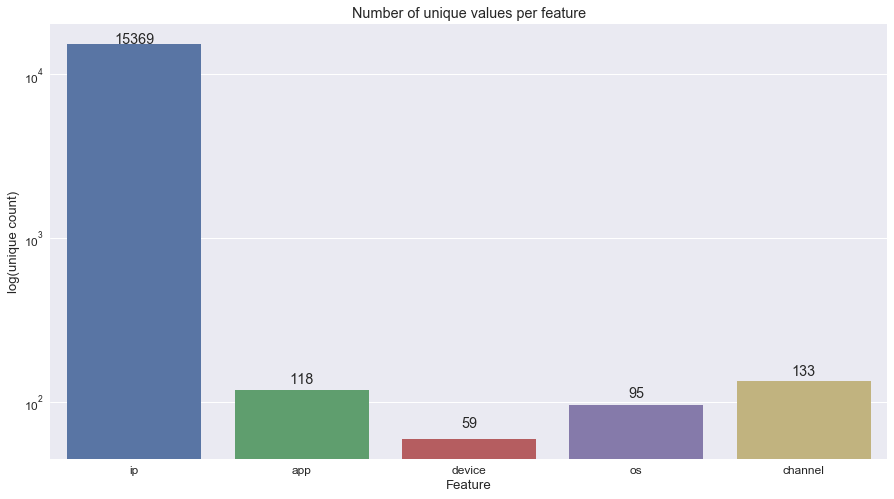

In [13]:
plt.figure(figsize=(15, 8))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

In [14]:
train[['attributed_time', 'is_attributed']][train['is_attributed']==1].describe()

,attributed_time,is_attributed
count,169,169.0
unique,161,1.0
top,2017-11-06 16:01:13,1.0
freq,3,169.0
first,2017-11-06 16:00:47,NaN
last,2017-11-07 15:53:02,NaN


In [15]:
test['click_id']=test['click_id'].astype('category')
test.describe()

,click_id,ip,app,device,os,channel,click_time
count,18790469.0,18790469.0,18790469.0,18790469.0,18790469.0,18790469.0,18790469
unique,18790469.0,93936.0,417.0,1985.0,395.0,178.0,21603
top,18790468.0,5348.0,9.0,1.0,19.0,107.0,2017-11-10 09:00:10
freq,1.0,182522.0,2872176.0,17360269.0,4334532.0,1214650.0,1466
first,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-10 04:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-10 15:00:00


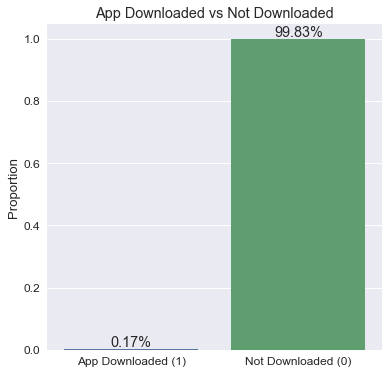

In [16]:
plt.figure(figsize=(6,6))
sns.set(font_scale=1.2)
mean = (train.is_attributed.values == 1).mean()
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='App Downloaded vs Not Downloaded')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

In [17]:
temp = train['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']
temp[:10]

,ip,counts
0,73487,610
1,73516,561
2,201182,363
3,5314,337
4,5348,314
5,105560,309
6,105475,305
7,114276,297
8,53454,297
9,100275,275


In [18]:
train= train.merge(temp, on='ip', how='left')

In [19]:
train[train['is_attributed']==1].sort_values('counts', ascending=False)[:10]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,counts
13481,73487,11,1,17,481,2017-11-06 16:00:18,2017-11-06 16:09:04,1,610
25498,3994,8,1,41,145,2017-11-06 16:00:32,2017-11-06 16:21:38,1,138
21951,147046,8,1,20,145,2017-11-06 16:00:28,2017-11-07 01:04:44,1,100
43377,130834,8,1,6,145,2017-11-06 16:00:48,2017-11-07 09:58:46,1,36
22477,109676,9,1,13,134,2017-11-06 16:00:28,2017-11-06 16:04:27,1,34
56053,114461,29,1,19,343,2017-11-06 16:01:00,2017-11-07 04:05:43,1,30
23289,71238,10,1,19,113,2017-11-06 16:00:29,2017-11-06 17:54:16,1,28
64464,18839,8,1,6,145,2017-11-06 16:01:09,2017-11-06 17:25:31,1,26
59625,81698,50,56,24,213,2017-11-06 16:01:04,2017-11-06 17:13:48,1,25
28989,119377,32,1,19,21,2017-11-06 16:00:35,2017-11-07 11:30:27,1,22


In [20]:
train[train['is_attributed']==1].ip.describe()

count        169
unique       169
top       163643
freq           1
Name: ip, dtype: int64

In [21]:
train['is_attributed']=train['is_attributed'].astype(int)

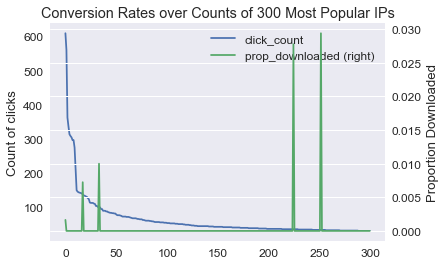

Counversion Rates over Counts of Most Popular IPs
        ip  click_count  prop_downloaded
0    73487          610         0.001639
1    73516          561         0.000000
2   201182          363         0.000000
3     5314          337         0.000000
4     5348          314         0.000000
5   105560          309         0.000000
6   105475          305         0.000000
7    53454          297         0.000000
8   114276          297         0.000000
9   100275          275         0.000000
10  188387          213         0.000000
11   95766          150         0.000000
12   43793          146         0.000000
13   26995          144         0.000000
14   93021          143         0.000000
15   17149          142         0.000000
16   86767          141         0.000000
17    3994          138         0.007246
18  114314          135         0.000000
19  111025          134         0.000000


In [22]:
proportion = train[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns = ['ip', 'click_count', 'prop_downloaded']

ax = merge[:300].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 300 Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular IPs')
print(merge[:20])

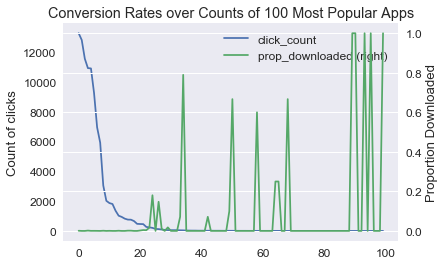

Counversion Rates over Counts of Most Popular Apps
   app  click_count  prop_downloaded
0    9        13280         0.000904
1   12        12826         0.000000
2   15        11568         0.000000
3    8        10938         0.001646
4    3        10916         0.000366
5    2         9269         0.000432
6   18         6959         0.000287
7    1         5929         0.000000
8   14         3053         0.000983
9    6         2024         0.000000
10  21         1871         0.000534
11  13         1809         0.000000
12  64         1357         0.000000
13  11         1023         0.000978
14  23          941         0.000000
15  25          824         0.000000
16  20          761         0.001314
17  26          756         0.001323
18  24          663         0.000000
19  28          477         0.000000


In [23]:
proportion = train[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='app', how='left')
merge.columns = ['app', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Apps')
print(merge[:20])

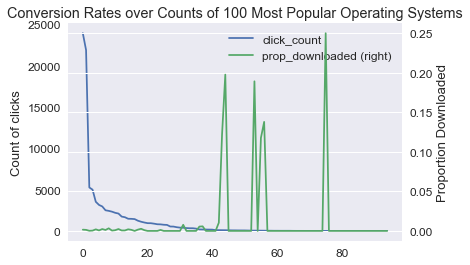

Counversion Rates over Counts of Most Popular Operating Systems
     os  click_count  prop_downloaded
0    19        23957         0.001586
1    13        21918         0.001323
2    17         5268         0.000190
3    18         5003         0.000400
4    22         3532         0.001982
5     8         3150         0.000635
6    10         2967         0.002359
7     9         2502         0.001199
8     6         2431         0.003291
9    15         2334         0.000428
10   25         2194         0.000912
11   20         2107         0.002373
12   16         1737         0.000576
13    3         1661         0.000602
14   41         1475         0.002034
15   14         1464         0.001366
16   37         1434         0.000000
17   12         1239         0.001614
18    1         1114         0.002693
19  607         1019         0.000981


In [24]:
proportion = train[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Operating Systems')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Operating Systems')
print(merge[:20])

In [25]:
proportion = train[['device', 'is_attributed']].groupby('device', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['device', 'is_attributed']].groupby('device', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='device', how='left')
merge.columns = ['device', 'click_count', 'prop_downloaded']

print('Count of clicks and proportion of downloads by device:')
print(merge[:20])

Count of clicks and proportion of downloads by device:
   device  click_count  prop_downloaded
0       1        94397         0.001314
1       2         4447         0.000000
2    3032          836         0.000000
3       0          224         0.116071
4      59           20         0.000000
5     211            4         0.250000
6      49            4         0.000000
7      33            4         0.250000
8      21            3         0.666667
9     251            3         0.333333
10     40            2         0.500000
11    685            2         0.500000
12    276            2         0.500000
13     16            2         0.000000
14     46            2         1.000000
15    537            2         0.000000
16    486            2         0.000000
17     90            2         0.000000
18   1532            2         0.500000
19    379            1         1.000000


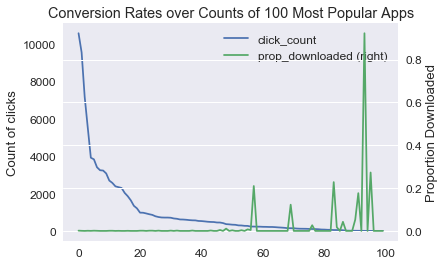

Counversion Rates over Counts of Most Popular Channels
   channel  click_count  prop_downloaded
0      145        10582         0.001323
1      134         9556         0.000523
2      245         7173         0.000000
3      140         5531         0.000723
4      259         3924         0.000255
5      215         3838         0.001042
6      280         3414         0.000586
7      477         3255         0.000000
8      121         3239         0.000000
9      178         3083         0.000000
10     107         2703         0.000740
11     442         2577         0.000776
12     265         2394         0.000000
13     153         2349         0.000426
14     459         2307         0.000000
15     205         2044         0.000000
16     128         1868         0.000535
17     125         1646         0.000000
18     379         1353         0.000000
19     135         1216         0.000000


In [26]:
proportion = train[['channel', 'is_attributed']].groupby('channel', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['channel', 'is_attributed']].groupby('channel', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='channel', how='left')
merge.columns = ['channel', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Channels')
print(merge[:20])

In [27]:
train_smp = pd.read_csv('./train_sample.csv')

In [28]:
train_smp.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [29]:
train_smp['click_time'] = pd.to_datetime(train_smp['click_time'])
train_smp['attributed_time'] = pd.to_datetime(train_smp['attributed_time'])

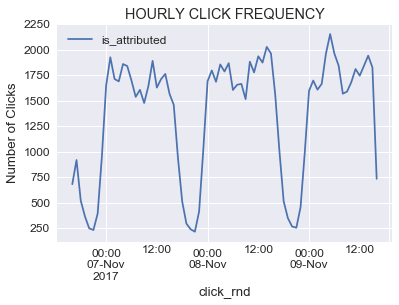

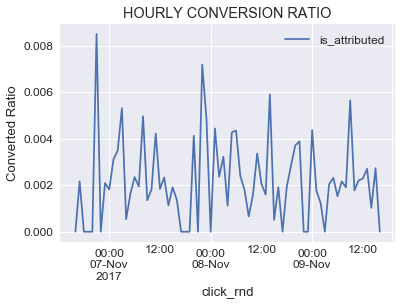

In [30]:
train_smp['click_rnd']=train_smp['click_time'].dt.round('H')  
train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY');
plt.ylabel('Number of Clicks');

train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).mean().plot()
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

In [31]:
train_smp['click_hour']=train_smp['click_time'].dt.hour
train_smp.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_rnd,click_hour
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,2017-11-07 10:00:00,9
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,2017-11-07 14:00:00,13
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,2017-11-07 18:00:00,18
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,2017-11-07 05:00:00,4
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,2017-11-09 09:00:00,9


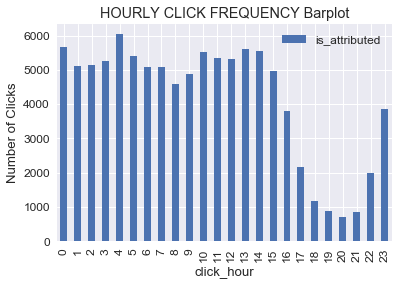

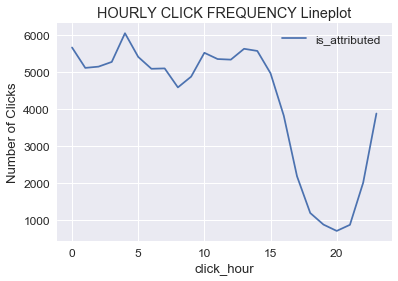

In [32]:
train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(kind='bar')
plt.title('HOURLY CLICK FREQUENCY Barplot');
plt.ylabel('Number of Clicks');

train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY Lineplot');
plt.ylabel('Number of Clicks');

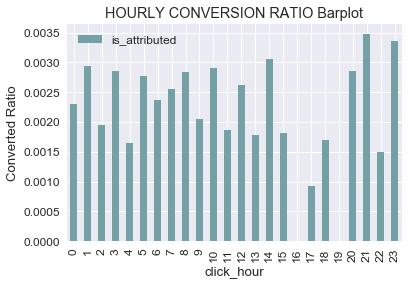

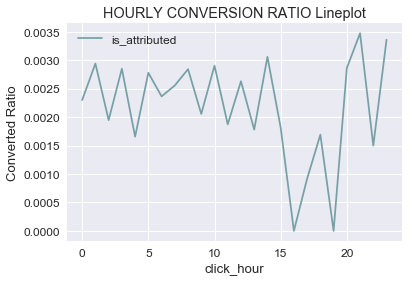

In [33]:
train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot(kind='bar', color='#75a1a6')
plt.title('HOURLY CONVERSION RATIO Barplot');
plt.ylabel('Converted Ratio');

train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot( color='#75a1a6')
plt.title('HOURLY CONVERSION RATIO Lineplot');
plt.ylabel('Converted Ratio');

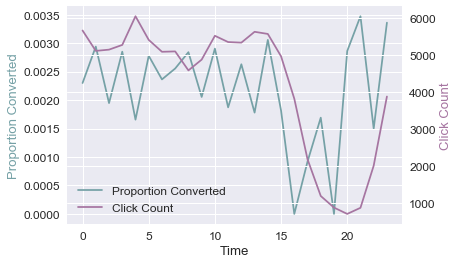

In [34]:
group = train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).mean()
x = group['click_hour']
ymean = group['is_attributed']
group = train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).count()
ycount = group['is_attributed']


fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Time")
host.set_ylabel("Proportion Converted")
par1.set_ylabel("Click Count")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, ymean, color=color1,label="Proportion Converted")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')

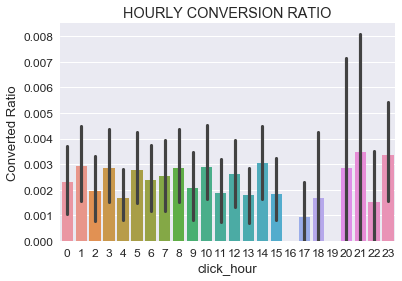

In [35]:
sns.barplot('click_hour', 'is_attributed', data=train_smp)
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

In [36]:
train_smp['timePass']= train_smp['attributed_time']-train_smp['click_time']
#check:
train_smp[train_smp['is_attributed']==1][:15]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_rnd,click_hour,timePass
284,224120,19,0,29,213,2017-11-08 02:22:13,2017-11-08 02:22:38,1,2017-11-08 02:00:00,2,00:00:25
481,272894,10,1,7,113,2017-11-08 06:10:05,2017-11-08 06:10:37,1,2017-11-08 06:00:00,6,00:00:32
1208,79001,19,0,0,213,2017-11-07 09:54:22,2017-11-07 11:59:05,1,2017-11-07 10:00:00,9,02:04:43
1341,131029,19,0,0,343,2017-11-09 10:58:46,2017-11-09 11:52:01,1,2017-11-09 11:00:00,10,00:53:15
1412,40352,19,0,0,213,2017-11-07 22:19:03,2017-11-08 01:55:02,1,2017-11-07 22:00:00,22,03:35:59
1666,48733,35,1,18,274,2017-11-07 12:25:50,2017-11-07 13:10:30,1,2017-11-07 12:00:00,12,00:44:40
1771,330861,35,1,22,21,2017-11-08 18:54:44,2017-11-08 22:39:52,1,2017-11-08 19:00:00,18,03:45:08
1917,309576,5,1,32,113,2017-11-09 08:47:51,2017-11-09 08:47:55,1,2017-11-09 09:00:00,8,00:00:04
3914,220571,71,1,25,3,2017-11-08 04:35:21,2017-11-08 04:37:46,1,2017-11-08 05:00:00,4,00:02:25
3992,240051,35,1,19,21,2017-11-08 08:07:13,2017-11-08 09:46:42,1,2017-11-08 08:00:00,8,01:39:29


In [37]:
train_smp['timePass'].describe()

count                       227
mean     0 days 01:14:59.572687
std      0 days 02:25:05.392661
min             0 days 00:00:02
25%      0 days 00:00:52.500000
50%             0 days 00:03:18
75%      0 days 01:21:27.500000
max             0 days 12:52:21
Name: timePass, dtype: object

In [38]:
train['timePass']= train['attributed_time']-train['click_time']
train['timePass'].describe()

count                       169
mean     0 days 06:17:25.668639
std      0 days 07:28:45.479005
min             0 days 00:00:03
25%             0 days 00:02:40
50%             0 days 01:12:44
75%             0 days 12:04:43
max             0 days 23:52:38
Name: timePass, dtype: object

In [39]:
y = train['is_attributed']
train.drop(['is_attributed'], axis=1, inplace=True)

In [40]:
sub = pd.DataFrame()
sub['click_id'] = test['click_id'].astype('int')

In [41]:
test.drop(['click_id'], axis=1, inplace=True)
gc.collect()
train.drop(['attributed_time'],axis=1,inplace=True)
gc.collect()
nrow_train = train.shape[0]
merge = pd.concat([train, test])
del train, test
gc.collect()

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


64

In [42]:
ip_count = merge.groupby(['ip'])['channel'].count().reset_index()
ip_count.columns = ['ip', 'clicks_by_ip']
merge = pd.merge(merge, ip_count, on='ip', how='left', sort=False)
merge['clicks_by_ip'] = merge['clicks_by_ip'].astype('uint16')
merge.drop('ip', axis=1, inplace=True)

In [43]:
merge.head()

,app,channel,click_time,counts,device,os,timePass,clicks_by_ip
0,3,379,2017-11-06 14:32:21,13.0,1,13,NaT,2379
1,3,379,2017-11-06 14:33:34,19.0,1,19,NaT,2120
2,3,379,2017-11-06 14:34:12,14.0,1,13,NaT,1225
3,14,478,2017-11-06 14:34:52,132.0,1,13,NaT,19724
4,3,379,2017-11-06 14:35:08,1.0,1,13,NaT,1


In [44]:
merge['datetime'] = pd.to_datetime(merge['click_time'])
merge['dow'] = merge['datetime'].dt.dayofweek
merge['doy'] = merge['datetime'].dt.dayofyear
merge.drop(['click_time', 'datetime','timePass'], axis=1, inplace=True)

In [45]:
variables = [ 'app', 'device', 'os', 'channel']
for v in variables:
    merge[v] = merge[v].astype('int')

In [46]:
train = merge[:nrow_train]
test = merge[nrow_train:]
del  merge
gc.collect()

86

In [48]:
x1, x2, y1, y2 = train_test_split(train, y, test_size=0.3, random_state=99)

In [56]:
model=svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(x1,y1)
prediction1=model.predict(x2)
print('Accuracy for rbf SVM is ',metrics.accuracy_score(prediction1,y2))

Accuracy for rbf SVM is  0.9984333333333333


In [ ]:
model=svm.SVC(kernel='linear',C=0.1,gamma=0.1)
model.fit(x1,y1)
prediction2=model.predict(x2)
print('Accuracy for linear SVM is',metrics.accuracy_score(prediction2,y2))

In [49]:
model = LogisticRegression()
model.fit(x1,y1)
prediction3=model.predict(x2)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,y2))

The accuracy of the Logistic Regression is 0.9986333333333334


In [50]:
model=DecisionTreeClassifier()
model.fit(x1,y1)
prediction4=model.predict(x2)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,y2))

The accuracy of the Decision Tree is 0.9982333333333333


In [51]:
model=KNeighborsClassifier() 
model.fit(x1,y1)
prediction5=model.predict(x2)
print('The accuracy of the KNN is',metrics.accuracy_score(prediction5,y2))

The accuracy of the KNN is 0.9983333333333333


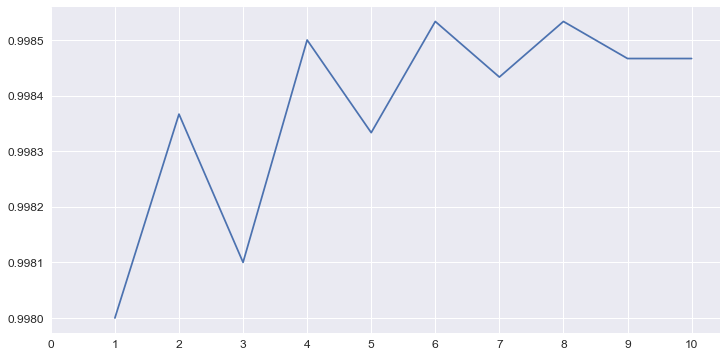

Accuracies for different values of n are: [0.998      0.99836667 0.9981     0.9985     0.99833333 0.99853333
 0.99843333 0.99853333 0.99846667 0.99846667] with the max value as  0.9985333333333334


In [52]:
a_index=list(range(1,11))
a=pd.Series()
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    model=KNeighborsClassifier(n_neighbors=i) 
    model.fit(x1,y1)
    prediction=model.predict(x2)
    a=a.append(pd.Series(metrics.accuracy_score(prediction,y2)))
plt.plot(a_index, a)
plt.xticks(x)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print('Accuracies for different values of n are:',a.values,'with the max value as ',a.values.max())

In [53]:
model=GaussianNB()
model.fit(x1,y1)
prediction6=model.predict(x2)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(prediction6,y2))

The accuracy of the NaiveBayes is 0.985


In [54]:
model=RandomForestClassifier(n_estimators=100)
model.fit(x1,y1)
prediction7=model.predict(x2)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction7,y2))

The accuracy of the Random Forests is 0.9984333333333333


In [55]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction

In [ ]:
kfold = KFold(n_splits=10, random_state=22)
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,train,y, cv = kfold,scoring = 'accuracy')
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

In [ ]:
plt.subplots(figsize=(12,6))
box=pd.DataFrame(accuracy,index=[classifiers])
box.T.boxplot()

In [ ]:
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)
plt.title('Average CV Mean Accuracy')
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()

In [ ]:
f,ax=plt.subplots(3,3,figsize=(12,10))
y_pred = cross_val_predict(svm.SVC(kernel='rbf'),train,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM')
y_pred = cross_val_predict(svm.SVC(kernel='linear'),train,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')
y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9),train,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),train,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')
y_pred = cross_val_predict(LogisticRegression(),train,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')
y_pred = cross_val_predict(DecisionTreeClassifier(),train,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')
y_pred = cross_val_predict(GaussianNB(),train,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for Naive Bayes')
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
C=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
gamma=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
kernel=['rbf','linear']
hyper={'kernel':kernel,'C':C,'gamma':gamma}
gd=GridSearchCV(estimator=svm.SVC(),param_grid=hyper,verbose=True)
gd.fit(train,y)
print(gd.best_score_)
print(gd.best_estimator_)

In [ ]:
from sklearn.ensemble import VotingClassifier
ensemble_lin_rbf=VotingClassifier(estimators=[('KNN',KNeighborsClassifier(n_neighbors=10)),
                                              ('RBF',svm.SVC(probability=True,kernel='rbf',C=0.5,gamma=0.1)),
                                              ('RFor',RandomForestClassifier(n_estimators=500,random_state=0)),
                                              ('LR',LogisticRegression(C=0.05)),
                                              ('DT',DecisionTreeClassifier(random_state=0)),
                                              ('NB',GaussianNB()),
                                              ('svm',svm.SVC(kernel='linear',probability=True))
                                             ], 
                       voting='soft').fit(x1,x2)
print('The accuracy for ensembled model is:',ensemble_lin_rbf.score(y1,y2))
cross=cross_val_score(ensemble_lin_rbf,train,y, cv = 10,scoring = "accuracy")
print('The cross validated score is',cross.mean())

In [ ]:
model=BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=0,n_estimators=100)
model.fit(x1,y1)
prediction=model.predict(x2)
print('The accuracy for bagged Decision Tree is:',metrics.accuracy_score(prediction,y2))
result=cross_val_score(model,train,y,cv=10,scoring='accuracy')
print('The cross validated score for bagged Decision Tree is:',result.mean())

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.1)
result=cross_val_score(ada,train,y,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoost is:',result.mean())

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
grad=GradientBoostingClassifier(n_estimators=500,random_state=0,learning_rate=0.1)
result=cross_val_score(grad,train,y,cv=10,scoring='accuracy')
print('The cross validated score for Gradient Boosting is:',result.mean())

In [ ]:
n_estimators=list(range(100,1100,100))
learn_rate=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
hyper={'n_estimators':n_estimators,'learning_rate':learn_rate}
gd=GridSearchCV(estimator=AdaBoostClassifier(),param_grid=hyper,verbose=True)
gd.fit(train,y)
print(gd.best_score_)
print(gd.best_estimator_)

In [ ]:
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.05)
result=cross_val_predict(ada,train,y,cv=10)
sns.heatmap(confusion_matrix(y,result),cmap='winter',annot=True,fmt='2.0f')
plt.show()

In [ ]:
f,ax=plt.subplots(2,2,figsize=(15,12))
model=RandomForestClassifier(n_estimators=500,random_state=0)
model.fit(train,y)
pd.Series(model.feature_importances_,train.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in Random Forests')
model=AdaBoostClassifier(n_estimators=200,learning_rate=0.05,random_state=0)
model.fit(train,y)
pd.Series(model.feature_importances_,train.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1],color='#ddff11')
ax[0,1].set_title('Feature Importance in AdaBoost')
model=GradientBoostingClassifier(n_estimators=500,learning_rate=0.1,random_state=0)
model.fit(train,y)
pd.Series(model.feature_importances_,train.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r')
ax[1,0].set_title('Feature Importance in Gradient Boosting')
model=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
model.fit(train,y)
pd.Series(model.feature_importances_,train.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,1].set_title('Feature Importance in XgBoost')
plt.show()

In [ ]:
params = {'eta': 0.3,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'max_depth': 0, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':0,
          'alpha':4,
          'objective': 'binary:logistic', 
          'scale_pos_weight':9,
          'eval_metric': 'auc', 
          'nthread':8,
          'random_state': 99, 
          'silent': True}

In [ ]:
import xgboost as xgb
from xgboost import plot_importance

In [ ]:
dtrain = xgb.DMatrix(x1, y1)
dvalid = xgb.DMatrix(x2, y2)
del x1, y1, x2, y2 
gc.collect()
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(params, dtrain, 200, watchlist, maximize=True, early_stopping_rounds = 25, verbose_eval=5)
del dvalid

In [ ]:
plot_importance(model)
plt.gcf().savefig('feature_importance_xgb.png')

In [ ]:
dtest = xgb.DMatrix(test)
del test
gc.collect()

In [ ]:
sub['is_attributed'] = model.predict(dtest, ntree_limit=model.best_ntree_limit)

In [ ]:
sub.to_csv('xgb_sub.csv', float_format='%.8f', index=False)